##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Core API のクイックスタート

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/guide/core/quickstart_core"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/guide/core/quickstart_core.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colabで実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/guide/core/quickstart_core.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/guide/core/quickstart_core.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

このクイックスタートチュートリアルでは、[TensorFlow Core 低レベル API](https://www.tensorflow.org/guide/core) を使用して、燃費を予測する重線形回帰モデルを構築し、トレーニングする方法を実演します。1970 年代後半から 1980 年代前半の自動車の燃費データを含む [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg){:.external} データセットを使用します。

一般的な機械学習のプロセスに従います。

1. データセットを読み込む
2. [入力パイプライン](../data.ipynb)を構築する
3. 重[線形回帰](https://developers.google.com/machine-learning/glossary#linear-regression){:.external} モデルを構築する
4. モデルのパフォーマンスを評価する

## セットアップ

まず、TensorFlow とその他の必要なライブラリをインポートします。

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
print("TensorFlow version:", tf.__version__)
# Set a random seed for reproducible results 
tf.random.set_seed(22)

2024-01-11 19:00:57.014206: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 19:00:57.014253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 19:00:57.015921: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.15.0


## データセットを読み込んで前処理する

次に、[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/){:.external} から [Auto MPG データセット](https://archive.ics.uci.edu/ml/datasets/auto+mpg){:.external} を読み込んで前処理する必要があります。このデータセットは、1970 年代後半から 1980 年代前半の自動車の燃費を予測するために、シリンダー、排気量、馬力、重量などのさまざまな量的およびカテゴリカル特徴を使用します。

データセットにはいくつかの不明な値が含まれています。 `pandas.DataFrame.dropna` で欠落している値を削除し、`tf.convert_to_tensor` と `tf.cast` 関数でデータセットを `tf.float32` テンソル型に変換します。

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = dataset.dropna()
dataset_tf = tf.convert_to_tensor(dataset, dtype=tf.float32)
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1

次に、データセットをトレーニングセットとテストセットに分割します。偏った分割を避けるために、必ず `tf.random.shuffle` でデータセットをシャッフルします。

In [4]:
dataset_shuffled = tf.random.shuffle(dataset_tf, seed=22)
train_data, test_data = dataset_shuffled[100:], dataset_shuffled[:100]
x_train, y_train = train_data[:, 1:], train_data[:, 0]
x_test, y_test = test_data[:, 1:], test_data[:, 0]

`"Origin"` 特徴をワンホットエンコードして、基本的な特徴量エンジニアリングを実行します。`tf.one_hot` 関数は、このカテゴリカル列を 3 つの個別のバイナリ列に変換するのに役立ちます。

In [5]:
def onehot_origin(x):
  origin = tf.cast(x[:, -1], tf.int32)
  # Use `origin - 1` to account for 1-indexed feature
  origin_oh = tf.one_hot(origin - 1, 3)
  x_ohe = tf.concat([x[:, :-1], origin_oh], axis = 1)
  return x_ohe

x_train_ohe, x_test_ohe = onehot_origin(x_train), onehot_origin(x_test)
x_train_ohe.numpy()

array([[  4., 140.,  72., ...,   1.,   0.,   0.],
       [  4., 120.,  74., ...,   0.,   0.,   1.],
       [  4., 122.,  88., ...,   0.,   1.,   0.],
       ...,
       [  8., 318., 150., ...,   1.,   0.,   0.],
       [  4., 156., 105., ...,   1.,   0.,   0.],
       [  6., 232., 100., ...,   1.,   0.,   0.]], dtype=float32)

この例は、予測変数または特徴量が大きく異なるスケールでの重回帰問題を示しています。したがって、各特徴の平均と単位分散がゼロになるようにデータを標準化します。標準化のために `tf.reduce_mean` および `tf.math.reduce_std` 関数を使用します。 その後、回帰モデルの予測を非標準化して、元の単位での値を取得できます。

In [6]:
class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.math.reduce_mean(x, axis=0)
    self.std = tf.math.reduce_std(x, axis=0)

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean

In [7]:
norm_x = Normalize(x_train_ohe)
norm_y = Normalize(y_train)
x_train_norm, y_train_norm = norm_x.norm(x_train_ohe), norm_y.norm(y_train)
x_test_norm, y_test_norm = norm_x.norm(x_test_ohe), norm_y.norm(y_test)

## 機械学習モデルを構築する

TensorFlow Core API を使用して線形回帰モデルを構築します。多重線形回帰の式は次のとおりです。

$${\mathrm{Y}} = {\mathrm{X}}w + b$$

ここでは、それぞれ以下を意味します。

- $\underset{m\times 1}{\mathrm{Y}}$: ターゲットベクトル
- $\underset{m\times n}{\mathrm{X}}$: 特徴行列
- $\underset{n\times 1}w$: 重みベクトル
- $b$: バイアス

`@tf.function` デコレータを使用することで、対応する Python コードがトレースされ、呼び出し可能な TensorFlow グラフが生成されます。このアプローチは、トレーニング後のモデルの保存と読み込みに役立ちます。また、複数のレイヤーと複雑な演算を含むモデルのパフォーマンスを向上させることもできます。 

In [8]:
class LinearRegression(tf.Module):

  def __init__(self):
    self.built = False

  @tf.function
  def __call__(self, x):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weight vector and bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1])
      rand_b = tf.random.uniform(shape=[])
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    y = tf.add(tf.matmul(x, self.w), self.b)
    return tf.squeeze(y, axis=1)

各例について、モデルは、その特徴の加重和とバイアス項を計算することにより、入力した自動車の MPG の予測を返します。そして、この予測を非標準化して、元の単位での値を取得します。

In [9]:
lin_reg = LinearRegression()
prediction = lin_reg(x_train_norm[:1])
prediction_unnorm = norm_y.unnorm(prediction)
prediction_unnorm.numpy()

array([6.8007355], dtype=float32)

## 損失関数を定義する

次に、損失関数を定義して、トレーニング中のモデルのパフォーマンスを評価します。

回帰問題は連続出力を扱うため、平均二乗誤差（MSE）は損失関数に最適です。MSE は次の式で定義されます。

$MSE = \frac{1}{m}\sum_{i=1}^{m}(\hat{y}_i -y_i)^2$

ここでは、それぞれ以下を意味します。

- $\hat{y}$: 予測のベクトル
- $y$: 真のターゲットのベクトル

この回帰問題の目標は、MSE 損失関数を最小化する最適な重みベクトル $w$ とバイアス $b$ を見つけることです。 

In [10]:
def mse_loss(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))

## モデルをトレーニングして評価する

トレーニングにミニバッチを使用すると、メモリ効率と収束の高速化を実現できます。`tf.data.Dataset` API には、バッチ処理とシャッフルに役立つ関数があります。API を使用すると、単純で再利用可能な部分から複雑な入力パイプラインを構築できます。TensorFlow 入力パイプラインの構築についての詳細は、[このガイド](https://www.tensorflow.org/guide/data)を参照してください。

In [11]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train_norm))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test_norm))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

次に、トレーニングループを記述して、MSE 損失関数と入力パラメータに対するその勾配を利用して、モデルのパラメータを繰り返し更新します。

この反復法は、[勾配降下法](https://developers.google.com/machine-learning/glossary#gradient-descent){:.external} と呼ばれます。各反復で、モデルのパラメータは、計算された勾配の反対方向にステップを実行することによって更新されます。このステップのサイズは、構成可能なハイパーパラメータである学習率によって決まります。関数の勾配は、最も急に上昇させる方向を示していることを思い出してください。したがって、反対方向に 1 歩進むことは、最も急に降下させる方向に進むことを示し、最終的に MSE 損失関数を最小化するのに役立ちます。

In [12]:
# Set training parameters
epochs = 100
learning_rate = 0.01
train_losses, test_losses = [], []

# Format training loop
for epoch in range(epochs):
  batch_losses_train, batch_losses_test = [], []

  # Iterate through the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = lin_reg(x_batch)
      batch_loss = mse_loss(y_pred_batch, y_batch)
    # Update parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, lin_reg.variables)
    for g,v in zip(grads, lin_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance 
    batch_losses_train.append(batch_loss)
  
  # Iterate through the testing data
  for x_batch, y_batch in test_dataset:
    y_pred_batch = lin_reg(x_batch)
    batch_loss = mse_loss(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance 
    batch_losses_test.append(batch_loss)

  # Keep track of epoch-level model performance
  train_loss = tf.reduce_mean(batch_losses_train)
  test_loss = tf.reduce_mean(batch_losses_test)
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  if epoch % 10 == 0:
    print(f'Mean squared error for step {epoch}: {train_loss.numpy():0.3f}')

# Output final losses
print(f"\nFinal train loss: {train_loss:0.3f}")
print(f"Final test loss: {test_loss:0.3f}")

Mean squared error for step 0: 2.866


Mean squared error for step 10: 0.453


Mean squared error for step 20: 0.285


Mean squared error for step 30: 0.231


Mean squared error for step 40: 0.209


Mean squared error for step 50: 0.203


Mean squared error for step 60: 0.194


Mean squared error for step 70: 0.184


Mean squared error for step 80: 0.186


Mean squared error for step 90: 0.176



Final train loss: 0.177
Final test loss: 0.157


MSE 損失の経時変化をプロットします。指定された[検証セット](https://developers.google.com/machine-learning/glossary#validation-set){:.external}または[テストセット](https://developers.google.com/machine-learning/glossary#test-set){:.external}でパフォーマンス指標を計算すると、モデルがトレーニングデータセットに対して過学習せず、トレーニングや検証に使用されていないデータに適切に一般化できることが保証されます。

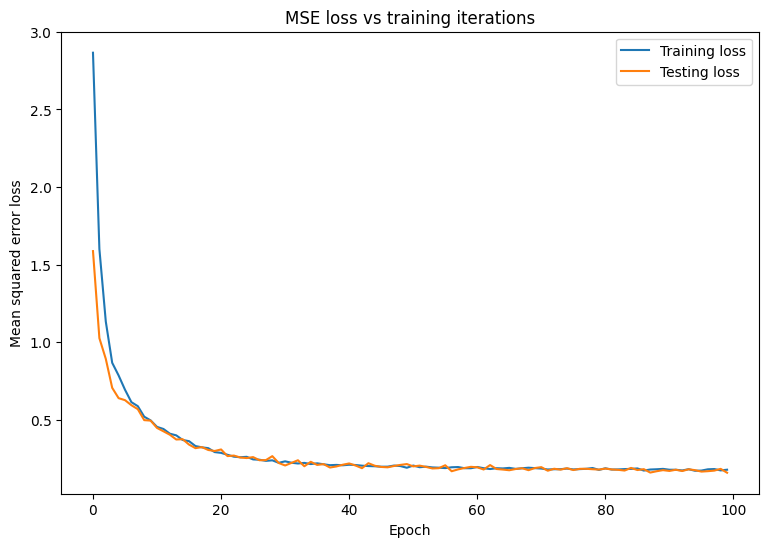

In [13]:
matplotlib.rcParams['figure.figsize'] = [9, 6]

plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Mean squared error loss")
plt.legend()
plt.title("MSE loss vs training iterations");

このモデルは、トレーニングデータを適切に適合し、使用されていないテストデータを適切に一般化しているように見えます。

## モデルを保存して読み込む

まず、生データを取り込み、次の演算を実行するエクスポートモジュールを作成します。

- 特徴を抽出する
- 正則化
- 予測
- 非正則化

In [14]:
class ExportModule(tf.Module):
  def __init__(self, model, extract_features, norm_x, norm_y):
    # Initialize pre and postprocessing functions
    self.model = model
    self.extract_features = extract_features
    self.norm_x = norm_x
    self.norm_y = norm_y

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)]) 
  def __call__(self, x):
    # Run the ExportModule for new data points
    x = self.extract_features(x)
    x = self.norm_x.norm(x)
    y = self.model(x)
    y = self.norm_y.unnorm(y)
    return y 

In [15]:
lin_reg_export = ExportModule(model=lin_reg,
                              extract_features=onehot_origin,
                              norm_x=norm_x,
                              norm_y=norm_y)

モデルをその時点の状態で保存する場合は、`tf.saved_model.save` 関数を使用して保存できます。保存されたモデルを読み込んで予測を行うには、`tf.saved_model.load` 関数を使用します。

In [16]:
import tempfile
import os

models = tempfile.mkdtemp()
save_path = os.path.join(models, 'lin_reg_export')
tf.saved_model.save(lin_reg_export, save_path)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpp2xg2fgo/lin_reg_export/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpp2xg2fgo/lin_reg_export/assets


In [17]:
lin_reg_loaded = tf.saved_model.load(save_path)
test_preds = lin_reg_loaded(x_test)
test_preds[:10].numpy()

array([28.097498, 26.193336, 33.564373, 27.719315, 31.787922, 24.014559,
       24.421043, 13.459579, 28.562454, 27.368692], dtype=float32)

## まとめ

TensorFlow Core の低レベル API を使用して回帰モデルをトレーニングしました。

TensorFlow Core API の使用例については、次のガイドを参照してください。

- [ロジスティック回帰](./logistic_regression_core.ipynb)で二項分類を実行する
- [多層パーセプトロン](./mlp_core.ipynb)で手書き数字を認識する
